# Data Pipeline

ah shit, 
here we go again
{insert cj meme here}

In [3]:
from _Setup import *

 TODO : Remove Columns w/ > 90% initial missing values (maybe not since it will get rid of most variables)

In [4]:
train_data = pd.read_pickle(rawTrainFilePickle)

test_data = pd.read_pickle(rawTestFilePickle)

submission_data = pd.read_csv(rawSubmissionFile)

# Train data preparation

In [5]:
# backward fill function
def backward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .bfill()
    )

    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

In [6]:
def forward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .ffill()
    )
    
    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

## TODO : Remove Columns w/ > 95% initial missing values and B/F imputation

In [7]:
# Identify columns with more than 90% missing values

missing_percentage = train_data.isnull().mean() * 100

cols_to_drop = missing_percentage[missing_percentage > 95].index

# Drop the identified columns

train_truncated = train_data.drop(columns=cols_to_drop)

In [8]:
#forward imputation
train_forward = forward_fill_by_patient(train_truncated)
train_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [9]:
#backward imputation
pre_imputed_train = backward_fill_by_patient(train_forward)
pre_imputed_train.head()  

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [10]:
# Identify columns with more than 90% missing values

missing_percentage = pre_imputed_train.isnull().mean() * 100

cols_to_drop2 = missing_percentage[missing_percentage > 80].index

print(cols_to_drop2)

Index([], dtype='object')


## MissForest imputation

In [11]:
pre_imputed_train.isna().sum()

patient             0
time                0
HR                142
O2Sat             328
Temp             5067
SBP              7543
MAP              2053
DBP            181559
Resp             1454
BaseExcess     693606
FiO2           545205
pH             513489
PaCO2          528467
BUN             34066
Calcium        104732
Creatinine      34523
Glucose         28393
Magnesium       95155
Potassium       32293
Hct             40045
Hgb             42004
WBC             44834
Platelets       43974
Age                 0
Gender              0
Unit1          426031
Unit2          426031
HospAdmTime         8
ICULOS              0
SepsisLabel         0
dtype: int64

In [12]:
# TODO : random sample of dataset before imputing data to save hours

sample_pool = pre_imputed_train.drop('SepsisLabel', axis = 1)

imputed_sample = pd.DataFrame(sample_pool.sample(n=10000), columns=sample_pool.columns)

imputer = MissForest()
imputer.fit(imputed_sample)

# NOTE :
This needs python 3.12 to get the .fit and .transforms funcitons on the MissForest imputer

In [13]:
imputed_data = imputer.transform(sample_pool)

imputed_data['SepsisLabel'] = pre_imputed_train['SepsisLabel']

imputed_data.isna().sum()

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [18:27<00:00, 221.43s/it]


patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

In [14]:
#correlation_matrix = imputed_data.corr()

# Mask the upper triangle
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
#plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
#sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
#plt.title('Lower Triangle Correlation Matrix of Imputed Train Data')
#plt.savefig('Plots/corrmat_train_imputed.png')
#plt.show()

# TODO : Put in correlation matrix here

In [15]:
#correlation_matrix = scaled_train.corr()

# Mask the upper triangle
#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
#plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
#sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
#plt.title('Lower Triangle Correlation Matrix of Imputed and Scaled Train Data')
#plt.savefig('Plots/corrmat_train_imputed.png')
#plt.show()

## TODO : SMOTE

In [17]:
X = imputed_data.drop(columns = ['SepsisLabel'])
y = imputed_data['SepsisLabel']


sm = SMOTE(sampling_strategy=0.3, k_neighbors=5, random_state=8)
X_train_syn, y_train_syn = sm.fit_resample(X, y)

print(imputed_data.iloc[:, 0:4].describe())
print(X_train_syn.iloc[:, 0:4].describe())

            patient          time            HR         O2Sat
count  1.088197e+06  1.088197e+06  1.088197e+06  1.088197e+06
mean   1.410742e+04  2.668297e+01  8.438115e+01  9.715170e+01
std    8.151722e+03  2.955474e+01  1.742592e+01  3.140354e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.200000e+01  9.600000e+01
50%    1.410100e+04  2.000000e+01  8.300000e+01  9.800000e+01
75%    2.118100e+04  3.400000e+01  9.500000e+01  9.900000e+01
max    2.823500e+04  4.250000e+02  2.110000e+02  1.001495e+02
            patient          time            HR         O2Sat
count  1.389147e+06  1.389147e+06  1.389147e+06  1.389147e+06
mean   1.412845e+04  3.291583e+01  8.575201e+01  9.711659e+01
std    8.159747e+03  4.027606e+01  1.793534e+01  3.179952e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.300000e+01  9.600000e+01
50%    1.416300e+04  2.200000e+01  8.450000e+01  9.800000e+01
75%    2

In [18]:
resampled_train = pd.concat([X_train_syn, y_train_syn], axis = 1)
resampled_train.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [19]:
# Before smote distribution 
sepsis_inf = train_data['SepsisLabel'].value_counts()
sepsis_percentages = (sepsis_inf / sepsis_inf.sum()) * 100
print(sepsis_percentages)

SepsisLabel
0.0    98.196924
1.0     1.803076
Name: count, dtype: float64


In [20]:
# After smote distribution
sepsis_inf2 = resampled_train['SepsisLabel'].value_counts()
sepsis_percentages2 = (sepsis_inf2 / sepsis_inf2.sum()) * 100
print(sepsis_percentages2)

SepsisLabel
0.0    76.923105
1.0    23.076895
Name: count, dtype: float64


## Scaling 

In [57]:
exclude_cols = ['patient', 'time', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']

# Separate columns into those to scale and those to exclude
cols_to_scale = resampled_train.drop(columns=exclude_cols + ['SepsisLabel']).columns
scaled_data = resampled_train[cols_to_scale]

# Scale the selected columns
scaler = StandardScaler()
scaled_scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data), columns=cols_to_scale)

# Combine scaled data with excluded columns and the target variable
scaled_train = pd.concat([scaled_scaled_data, resampled_train[exclude_cols], resampled_train['SepsisLabel']], axis=1)

# Display the resulting DataFrame
print(scaled_train.head())

         HR     O2Sat      Temp       SBP       MAP       DBP      Resp  \
0 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292 -1.294263   
1 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292 -1.294263   
2 -0.320708  0.592277 -0.914129 -0.428503  0.299849  0.716228 -1.294263   
3 -0.376464  0.906747 -0.531932 -0.471343  0.053772  0.346308 -1.294263   
4 -0.710999  0.906747 -0.531932 -0.342823 -0.130785  0.050372 -1.479445   

   BaseExcess      FiO2        pH  ...  Platelets       Age  patient  time  \
0    0.045536  0.073114  0.340467  ...  -0.431184 -0.299413    16426     1   
1    0.045536  0.073114  0.340467  ...  -0.431184 -0.299413    16426     2   
2    0.045536 -0.000054  0.710267  ...  -0.431184 -0.299413    16426     3   
3   -0.768098 -0.000054 -0.029333  ...  -0.431184 -0.299413    16426     4   
4   -0.768098 -0.014687 -0.029333  ...  -0.431184 -0.299413    16426     5   

   Gender  Unit1  Unit2  HospAdmTime  ICULOS  SepsisLabel  
0     1.0    0.0    

In [50]:
#exclude_cols = ['patient', 'time', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']

# Separate columns into those to scale and those to exclude
#cols_to_scale = resampled_train.drop(columns=exclude_cols).columns

# Scale the selected columns
#scaler = StandardScaler()
#scaled_data = pd.DataFrame(scaler.fit_transform(resampled_train[cols_to_scale]), columns=cols_to_scale)

# Combine scaled data with excluded columns
#scaled_train = pd.concat([scaled_data, resampled_train[exclude_cols].reset_index(drop=True)], axis=1)

# Display the resulting DataFrame
#print(scaled_train.head())


         HR     O2Sat      Temp       SBP       MAP       DBP      Resp  \
0 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292 -1.294263   
1 -0.432220  0.749512 -2.124421 -0.621283  0.146051  0.420292 -1.294263   
2 -0.320708  0.592277 -0.914129 -0.428503  0.299849  0.716228 -1.294263   
3 -0.376464  0.906747 -0.531932 -0.471343  0.053772  0.346308 -1.294263   
4 -0.710999  0.906747 -0.531932 -0.342823 -0.130785  0.050372 -1.479445   

   BaseExcess      FiO2        pH  ...  Platelets       Age  patient  time  \
0    0.045536  0.073114  0.340467  ...  -0.431184 -0.299413    16426     1   
1    0.045536  0.073114  0.340467  ...  -0.431184 -0.299413    16426     2   
2    0.045536 -0.000054  0.710267  ...  -0.431184 -0.299413    16426     3   
3   -0.768098 -0.000054 -0.029333  ...  -0.431184 -0.299413    16426     4   
4   -0.768098 -0.014687 -0.029333  ...  -0.431184 -0.299413    16426     5   

   Gender  Unit1  Unit2  HospAdmTime  ICULOS  SepsisLabel  
0     1.0    0.0    

## Correlation Matrixes for train data set pipeline

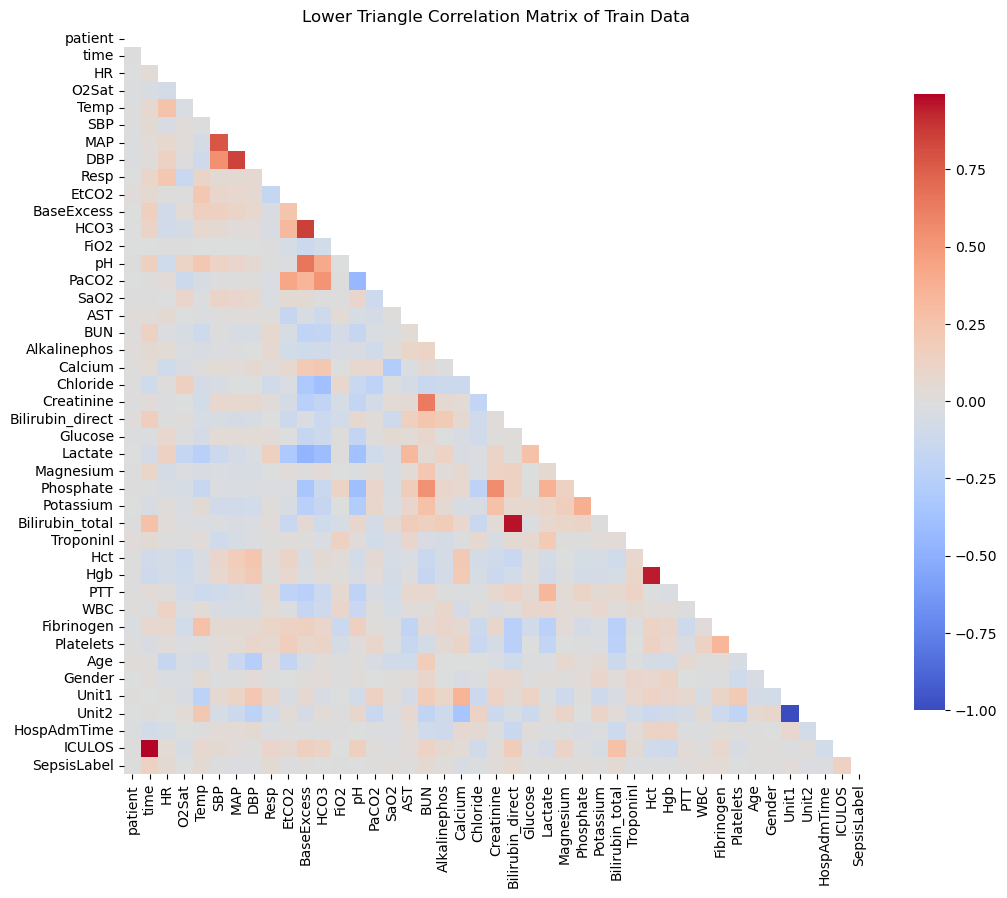

In [51]:
correlation_matrix = train_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

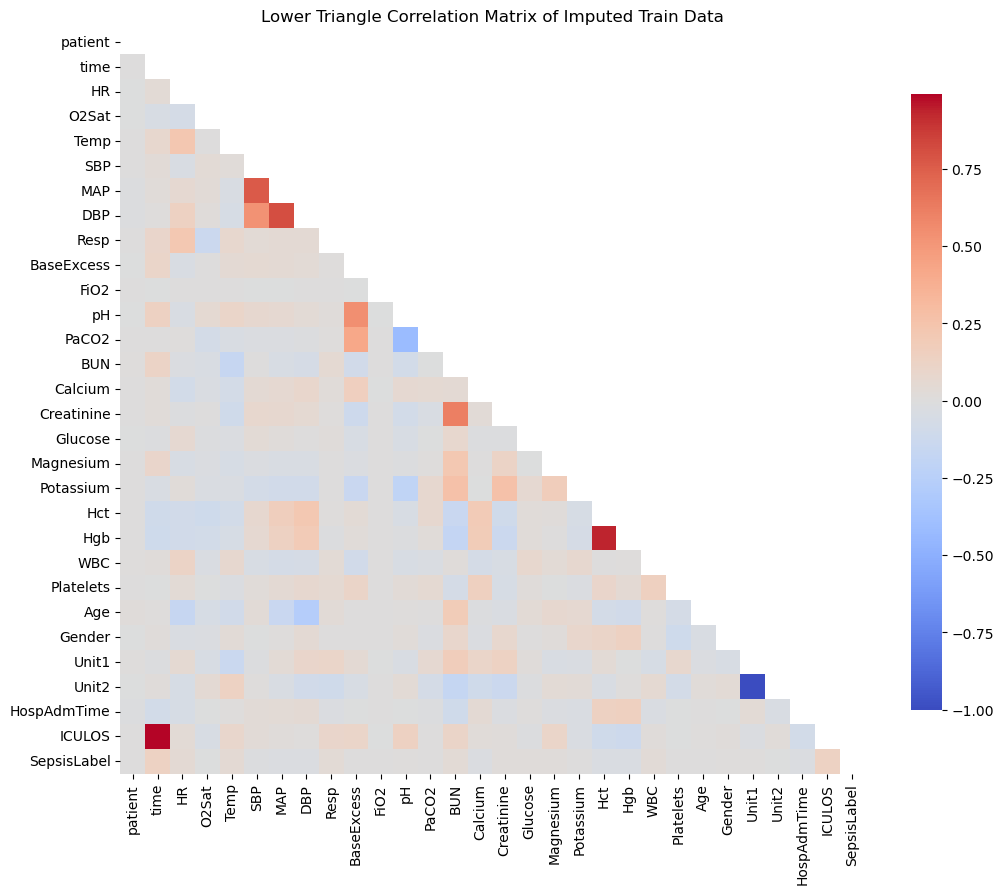

In [52]:
correlation_matrix = imputed_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

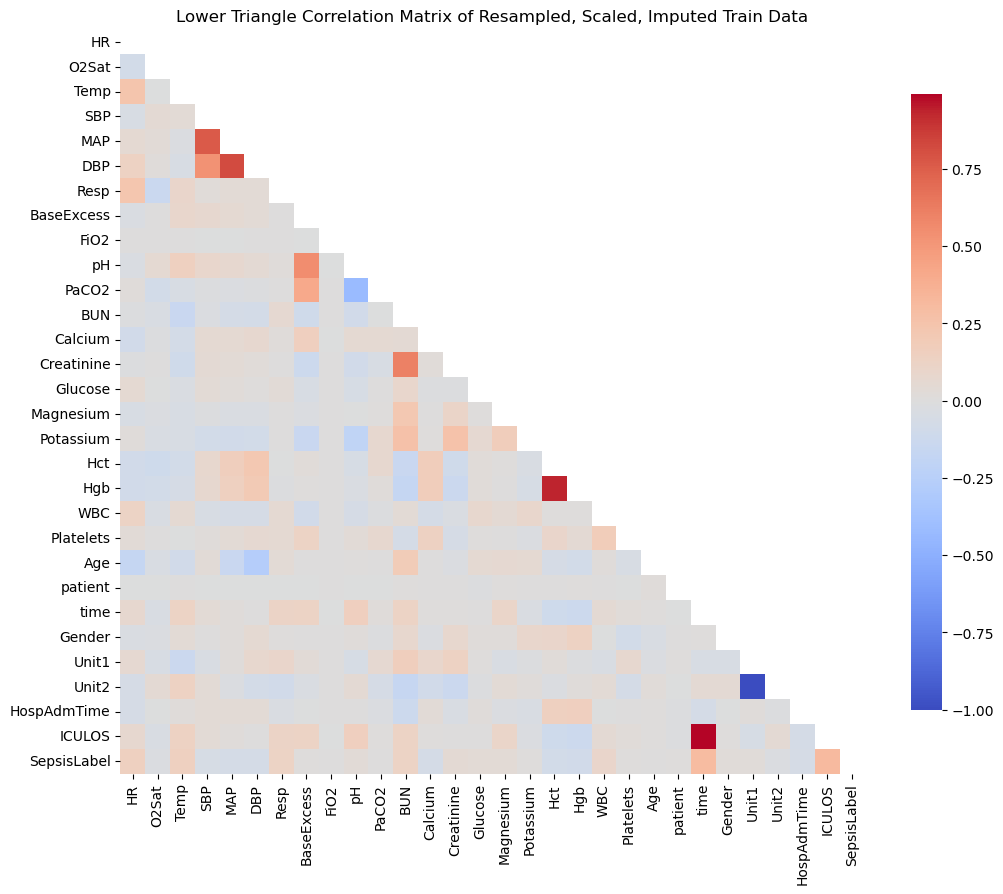

In [58]:
correlation_matrix = scaled_train.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Resampled, Scaled, Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for train data set pipeline

In [ ]:
def plot_all_variable_distributions(df):
    """
    Plots the distribution of all numerical variables in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    
    num_vars = len(num_cols)
    plt.figure(figsize=(15, 5 * num_vars))
    
    for i, col in enumerate(num_cols):
        plt.subplot(num_vars, 1, i + 1)  
        sns.histplot(df[col], kde=True, bins=30, color='blue')  
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
    plt.tight_layout()  
    plt.show()


plot_all_variable_distributions(train_data)

In [ ]:
plot_all_variable_distributions(imputed_train)

In [ ]:
plot_all_variable_distributions(resampled_train)

## Final train data set to csv

In [21]:
# get rid of the index
scaled_train.to_csv(missForestTrainFile)

# TEST PIPELINE

## Imputing B/F and missforest

In [28]:
test_dropped = test_data.drop(cols_to_drop, axis = 1)
test_dropped.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,NaN,101.0,69.67,NaN,NaN,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,NaN,125.0,75.67,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,NaN,150.0,94.67,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,6.0


In [29]:
#forward imputation
test_forward = forward_fill_by_patient(test_dropped)
test_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,6.0


In [30]:
#forward imputation
pre_imputed_test = backward_fill_by_patient(test_forward)
pre_imputed_test.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,6.0


## TODO : Find number of missing here

In [31]:
# forward fill 
pre_imputed_test['HR'] = pd.to_numeric(pre_imputed_test['HR'], errors='coerce')

# TODO : ERROR - SEPSIS LABEL IN FIRST SCALER, TAKE IT OUT

pre_imputed_test2 = imputer.transform(pre_imputed_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:02<00:00, 84.45s/it]


In [32]:
pre_imputed_test2.isna().sum()

patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
dtype: int64

## Scaling

In [60]:
pre_imputed_test2.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,58.356947,16.0,-0.047815,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,54.953000,16.0,-0.068351,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,56.627238,16.0,-0.068351,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,69.980597,16.0,-0.068351,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,50.876622,16.0,-0.068351,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,6.0


In [59]:
# SCALING WHILE OMITING SOME VARIABLES FIXED# 

indices_test2 = pre_imputed_test2.isna()

# Create Simple Imputer to fill NaN values with the mean for test data
# imputer = SimpleImputer(strategy='mean') -- needs to be the same imputer as used on the train data for correct scaling proportion
imputed_test = pd.DataFrame(imputer.transform(pre_imputed_test2), columns=pre_imputed_test2.columns)

# Separate columns into those to scale and those to exclude (no target variable in test)
cols_to_scale_test = imputed_test.drop(columns=exclude_cols).columns

# Scale the selected columns using the already-fitted scaler
scaled_test_data = pd.DataFrame(scaler.transform(imputed_test[cols_to_scale_test]), columns=cols_to_scale_test)

# Combine scaled data with excluded columns
scaled_test = pd.concat([scaled_test_data, imputed_test[exclude_cols]], axis=1)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Gender
- HospAdmTime
- ICULOS
- Unit1
- Unit2
- ...


## Correlation matrixes for test data set pipeline

In [ ]:
correlation_matrix = test_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

In [ ]:
correlation_matrix = scaled_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Scaled, Imputed Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for test data pipeline

In [ ]:
plot_all_variable_distributions(scaled_test)

In [ ]:
plot_all_variable_distributions(scaled_test)

## Final test data set to csv 

In [26]:
#get rid of the index
scaled_test.to_csv(os.path.join(imputedDataPath, "missforest_imputed_test.csv"))